In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf

2022-08-18 10:38:05.302337: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-18 10:38:05.302378: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf.keras.backend.set_floatx('float64')

In [3]:
DATA_QBITS = 9
LATENT_QBITS = 4
TRASH_QBITS = DATA_QBITS - LATENT_QBITS
TOTAL_QBITS = DATA_QBITS + TRASH_QBITS + 1

INPUT_DATA_SIZE = 9 # image width

DRCs = 1

### data 

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

x_train_threes = np.array(x_train[y_train==True])
x_train = np.array(x_train[y_train==False])

x_test_threes = np.array(x_test[y_test==True])
x_test = np.array(x_test[y_test==False])

In [5]:
x_train = x_train.reshape((x_train.shape[0],28,28,1))
x_test = x_test.reshape((x_test.shape[0],28,28,1))

x_train_threes = x_train_threes.reshape((x_train_threes.shape[0],28,28,1))
x_test_threes = x_test_threes.reshape((x_test_threes.shape[0],28,28,1))

In [6]:
SCALING = 20

x_train_small = tf.image.resize(x_train, (SCALING,SCALING)).numpy()
x_test_small = tf.image.resize(x_test, (SCALING,SCALING)).numpy()

x_train_3_small = tf.image.resize(x_train_threes, (SCALING,SCALING)).numpy()
x_test_3_small = tf.image.resize(x_test_threes, (SCALING,SCALING)).numpy()

2022-08-17 16:59:18.200415: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-17 16:59:18.200438: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-17 16:59:18.200455: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-08-17 16:59:18.200831: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### circuit

In [7]:
dev1 = qml.device('default.qubit', wires=TOTAL_QBITS)

In [8]:
def single_upload(params, data, wire):
    for i, d in enumerate(tf.reshape(data, [-1])):
        if i % 3 == 0:
            qml.RX(params[i * 2] + params[i * 2 + 1] * d, wires=wire)
        if i % 3 == 1:
            qml.RY(params[i * 2] + params[i * 2 + 1] * d, wires=wire)
        if i % 3 == 2:
            qml.RZ(params[i * 2] + params[i * 2 + 1] * d, wires=wire)

def conv_upload(params, img, kernel_size, stride, wires):
    number_of_kernel_uploads = len(list(range(0,INPUT_DATA_SIZE-kernel_size+1,stride)))*len(list(range(0,INPUT_DATA_SIZE-kernel_size+1,stride)))
    params_per_upload = len(params) // number_of_kernel_uploads
    upload_counter = 0
    wire = 0
    #for y in range(0,INPUT_DATA_SIZE-kernel_size+1,stride):
    #    for x in range(0,INPUT_DATA_SIZE-kernel_size+1,stride):
    #        single_upload(params[upload_counter * params_per_upload: (upload_counter + 1) * params_per_upload],
    #                      img[y:y+kernel_size, x:x+kernel_size], wires[wire])
    #        upload_counter = upload_counter + 1
    #        wire = wire + 1
    for y in range(0, INPUT_DATA_SIZE ** 2, stride ** 2):
        single_upload(params[upload_counter * params_per_upload: (upload_counter + 1) * params_per_upload],
                      img[y:y+stride**2], wires[wire])
        upload_counter = upload_counter + 1
        wire = wire + 1
            
def circular_entanglement(wires):
    qml.CNOT(wires=[wires[-1], 0] )
    for i in range(len(wires)-1):
        qml.CNOT(wires=[i, i+1])

@qml.qnode(dev1, diff_method="adjoint")
def circuit(inputs, weights):
    #inputs = inputs.numpy()
    kernel_size = 3
    stride = 3
    #print(weights)
    #print(inputs)
    #inputs = inputs.reshape(INPUT_DATA_SIZE, INPUT_DATA_SIZE)
    #print(inputs.shape)
    
    number_of_kernel_uploads = len(list(range(0,INPUT_DATA_SIZE-kernel_size+1,stride)))**2
    num_upload_params = number_of_kernel_uploads*2*kernel_size**2
    
    for i in range(DRCs):
        conv_upload(weights[i*num_upload_params:(i+1)*num_upload_params], inputs, kernel_size, stride, list(range(number_of_kernel_uploads)))
        circular_entanglement(list(range(number_of_kernel_uploads)))

    qml.Hadamard(wires=TOTAL_QBITS-1)
    for i in range(TRASH_QBITS):
        #c += cirq.ControlledGate(sub_gate=cirq.SWAP, num_controls=1).on(swap_qbit, reference_qbits[i], network_qbits[num_data_qbits - num_latent_qbits:][i])
        qml.CSWAP(wires=[TOTAL_QBITS - 1, LATENT_QBITS + i, DATA_QBITS + i])
    qml.Hadamard(wires=TOTAL_QBITS-1)
    return qml.expval(qml.PauliZ(TOTAL_QBITS-1))

In [9]:
data = np.random.rand(INPUT_DATA_SIZE*INPUT_DATA_SIZE)

kernel_size = 3
stride = 3
number_of_kernel_uploads = len(list(range(0,INPUT_DATA_SIZE-kernel_size+1,stride)))**2
num_upload_params = number_of_kernel_uploads*2*kernel_size**2

/tmp/ipykernel_371065/4246226403.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


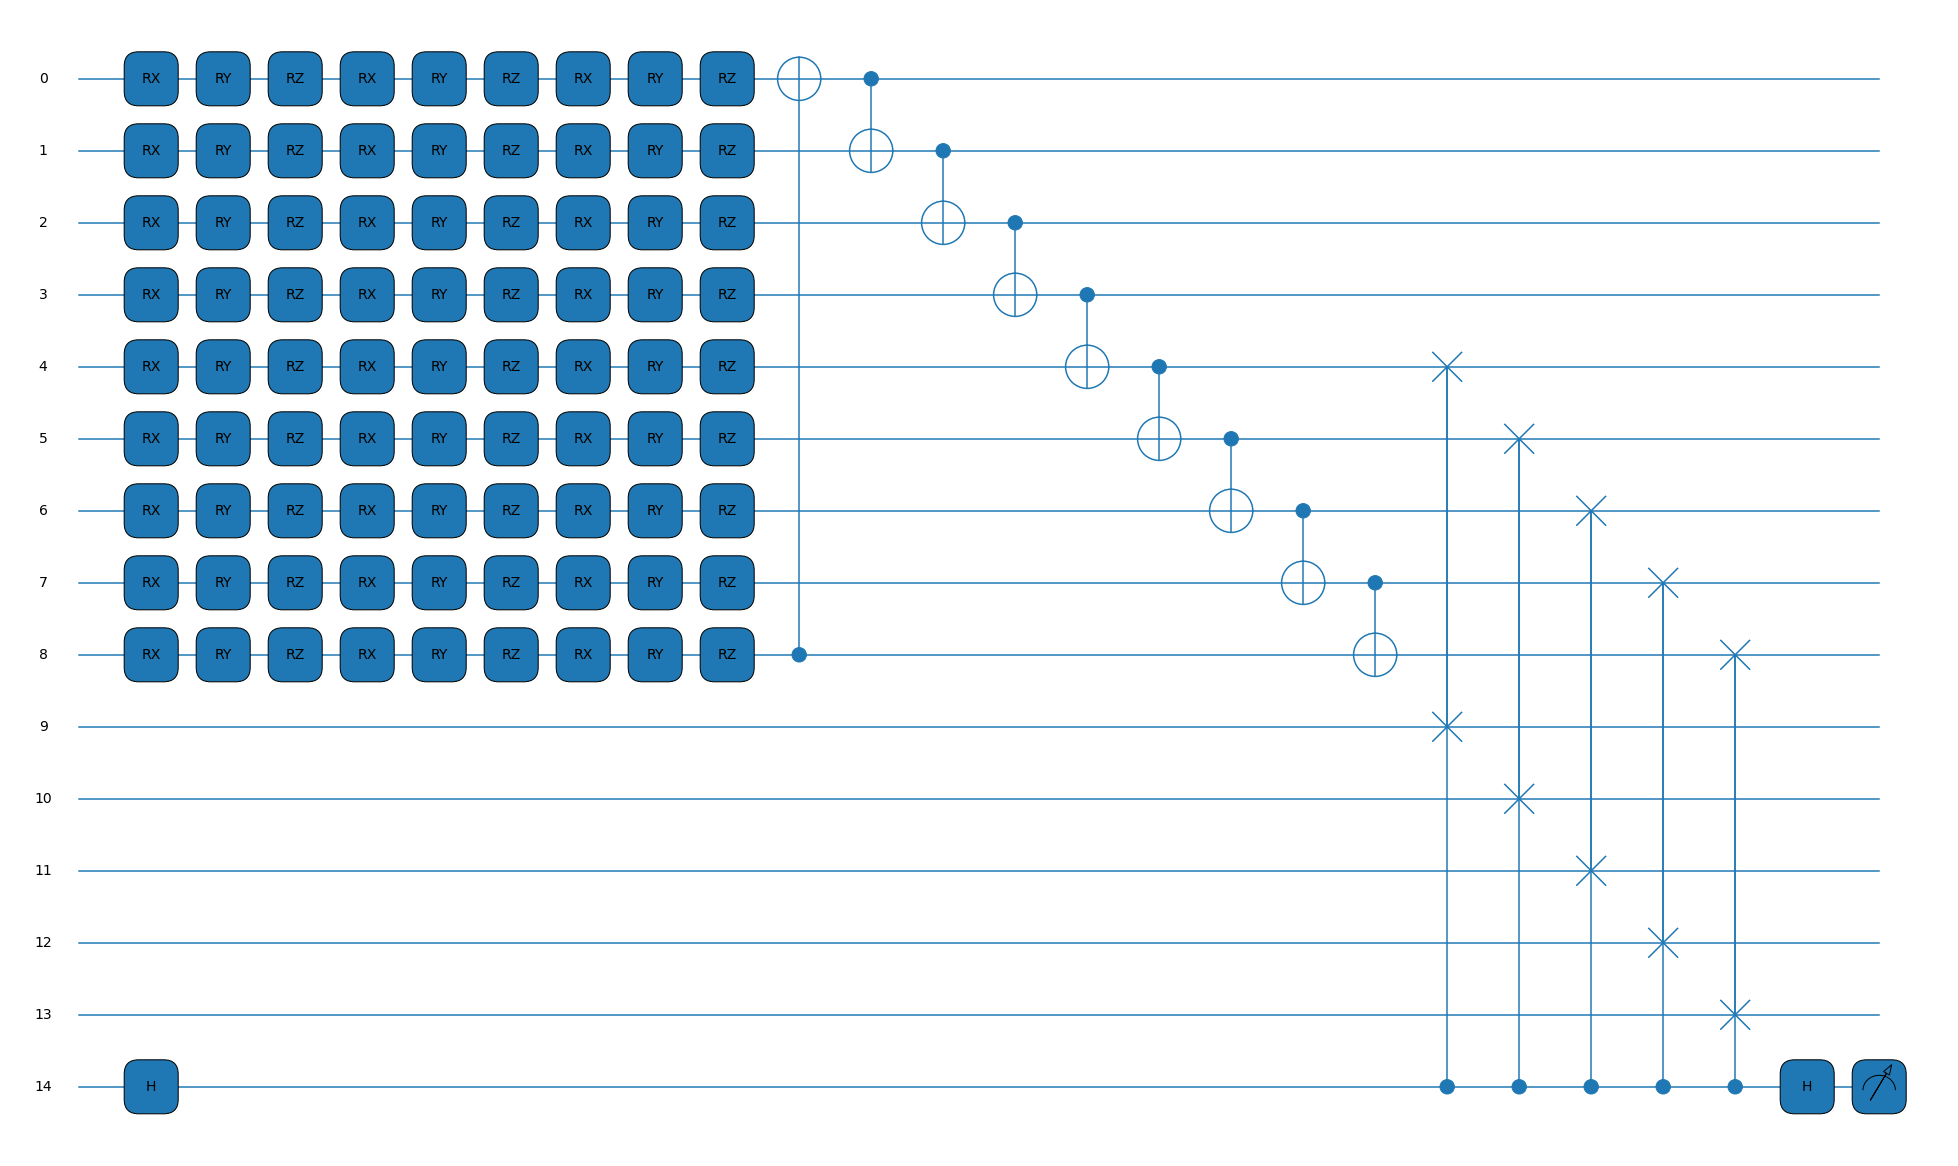

In [10]:
fig, ax = qml.draw_mpl(circuit)(data,np.ones(DRCs*num_upload_params))
fig.show()

In [11]:
weight_shapes = {"weights": (DRCs*num_upload_params,)}

In [12]:
qlayer = qml.qnn.KerasLayer(circuit, weight_shapes, output_dim=1)

### hybrid

In [13]:
inputs = tf.keras.layers.Input(shape=(20,20,1))
clayer_1 = tf.keras.layers.Conv2D(10, 3, strides=2, padding='valid', activation="relu")
clayer_2 = tf.keras.layers.Conv2D(1, 2, strides=1, padding='same', activation="relu")
dress1 = tf.keras.layers.Flatten()

#dress1 = tf.keras.layers.Reshape((9*9,))
#dress2 = tf.keras.layers.Dense(1)
#clayer_3 = tf.keras.layers.Conv2DTranspose(10, 4, strides=2, padding='valid', activation="relu")
#out_layer = tf.keras.layers.Conv2DTranspose(1, 2, strides=1, padding='same', activation="sigmoid")

In [14]:
model = tf.keras.models.Sequential([inputs, clayer_1, clayer_2, dress1, qlayer])

In [15]:
opt = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(opt, loss="mse")

In [16]:
model.build(input_shape=(20,20,1))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 10)          100       
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 1)           41        
                                                                 
 flatten (Flatten)           (None, 81)                0         
                                                                 
 keras_layer (KerasLayer)    (None, 1)                 0 (unused)
                                                                 
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [18]:
x_train_small = x_train_small[:1000]
x_test_small = x_test_small[:1000]

x_train_3_small = x_train_3_small[:1000]
x_test_3_small = x_test_3_small[:1000]

In [19]:
y_train_small = np.ones(x_train_small.shape[0])
y_test_small = np.ones(x_test_small.shape[0])

In [20]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,min_delta=0.0001)
fitting = model.fit(x_train_small, y_train_small, epochs=3, batch_size=20, validation_data=(x_test_small, y_test_small))

Epoch 1/3
50/50 [==============================] - 622s 12s/step - loss: 6.9510e-04
Epoch 2/3
50/50 [==============================] - 594s 12s/step - loss: 6.3369e-07
Epoch 3/3
50/50 [==============================] - 595s 12s/step - loss: 1.3245e-08


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 10)          100       
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 1)           41        
                                                                 
 flatten (Flatten)           (None, 81)                0         
                                                                 
 keras_layer (KerasLayer)    (None, 1)                 162       
                                                                 
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________


In [30]:
pred_six = model(x_test_small)#np.array([model(i) for i in x_test_small])
print("Median six reconstruciton fidelities: ",np.median(pred_six))

pred_three = model(x_test_3_small)#np.array([circuit(params,i) for i in x_test_3_small])
print("Median three reconstruciton fidelities: ",np.median(pred_three))

Median six reconstruciton fidelities:  0.9999339707808231
Median three reconstruciton fidelities:  0.9999339707808231


In [33]:
import matplotlib.pyplot as plt
bins = np.histogram(np.hstack((pred_six.reshape((pred_six.shape[0],)), pred_three.reshape((pred_three.shape[0],)))), bins=10)[1]
plt.hist(pred_six, histtype='step', label="sixes",bins=bins)
plt.hist(pred_three, histtype='step', label="threes",bins=bins)

AttributeError: 
        'EagerTensor' object has no attribute 'reshape'.
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()

AUC:  0.5


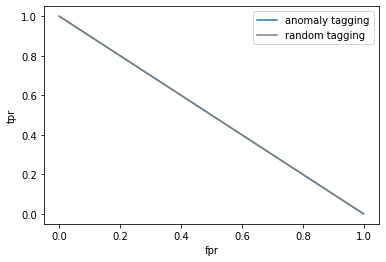

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve

bce_background = 1-pred_six
bce_signal = 1-pred_three

y_true = np.append(np.zeros(len(bce_background)), np.ones(len(bce_signal)))
y_pred = np.append(bce_background, bce_signal)
auc = roc_auc_score(y_true, y_pred)

print("AUC: ", auc)

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
tnr = 1 - fpr
x = np.linspace(0,1,50)
y_rnd = 1 - x
plt.plot(tnr,tpr, label="anomaly tagging")
plt.plot(x,y_rnd, label="random tagging", color='grey')
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()